## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2021-07-12 02:26:06--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.188.206, 2607:f8b0:4004:836::200e
Connecting to drive.google.com (drive.google.com)|142.250.188.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l9ohigtpbd3augagrh5egk8qovdelkkd/1626056700000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2021-07-12 02:26:09--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l9ohigtpbd3augagrh5egk8qovdelkkd/1626056700000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.81.193, 2607:f8b0:4004:82f::2001
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|142.250.81.19

### Preprocessing

Let's perform some basic preprocessing to get rid of punctuation and make everything lowercase. We'll then split the lyrics up by line and tokenize the lyrics.

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:10]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'and': 3, 'a': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'ma': 10, 'it': 11, 'of': 12, 'im': 13, 'your': 14, 'love': 15, 'so': 16, 'as': 17, 'that': 18, 'in': 19, 'andante': 20, 'boomaboomerang': 21, 'make': 22, 'on': 23, 'oh': 24, 'for': 25, 'but': 26, 'new': 27, 'bang': 28, 'its': 29, 'be': 30, 'like': 31, 'know': 32, 'now': 33, 'how': 34, 'could': 35, 'youre': 36, 'sing': 37, 'never': 38, 'no': 39, 'chiquitita': 40, 'can': 41, 'we': 42, 'song': 43, 'had': 44, 'good': 45, 'youll': 46, 'she': 47, 'just': 48, 'girl': 49, 'again': 50, 'will': 51, 'take': 52, 'please': 53, 'let': 54, 'am': 55, 'eyes': 56, 'was': 57, 'always': 58, 'cassandra': 59, 'blue': 60, 'time': 61, 'dont': 62, 'were': 63, 'return': 64, 'once': 65, 'then': 66, 'sorry': 67, 'cryin': 68, 'over': 69, 'feel': 70, 'ever': 71, 'believe': 72, 'what': 73, 'do': 74, 'go': 75, 'all': 76, 'out': 77, 'think': 78, 'every': 79, 'leave': 80, 'look': 81, 'at': 82, 'way': 83, 'one': 84, 'music': 85, 'down': 

### Create Sequences and Labels

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with `texts_to_sequences`, but also including the use of [N-Grams](https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9); creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [6]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [8]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])

32
97
[  0   0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29
   4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

#Model


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
62/62 [==============================] - 9s 7ms/step - loss: 5.9884 - accuracy: 0.0272
Epoch 2/200
62/62 [==============================] - 0s 7ms/step - loss: 5.4380 - accuracy: 0.0338
Epoch 3/200
62/62 [==============================] - 0s 7ms/step - loss: 5.3617 - accuracy: 0.0358
Epoch 4/200
62/62 [==============================] - 0s 6ms/step - loss: 5.3015 - accuracy: 0.0409
Epoch 5/200
62/62 [==============================] - 0s 7ms/step - loss: 5.2296 - accuracy: 0.0434
Epoch 6/200
62/62 [==============================] - 0s 6ms/step - loss: 5.1598 - accuracy: 0.0489
Epoch 7/200
62/62 [==============================] - 0s 7ms/step - loss: 5.0907 - accuracy: 0.0474
Epoch 8/200
62/62 [==============================] - 0s 7ms/step - loss: 5.0133 - accuracy: 0.0530
Epoch 9/200
62/62 [==============================] - 0s 6ms/step - loss: 4.9310 - accuracy: 0.0570
Epoch 10/200
62/62 [==============================] - 0s 7ms/step - loss: 4.8350 - accuracy: 0.0651
Epoch 11/

### View the Training Graph

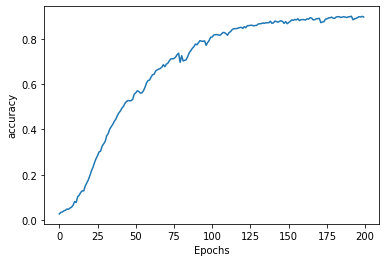

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate new lyrics

In [12]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me sing you make me sound and is yourself a break break break break break break would chiquitita am sucker weave break break god god god weave making mad god weave making mad do god weave do god god god weave dumb god weave god god weave god god making weave making give had to making mad do break break do god god god god weave making mad strong break yourself sound god god weave god around dumb god weave would weave god around mad do fingers god weave weave would weave god around life life eyes at talk own
